<a href="https://colab.research.google.com/github/AmjedKhaled165/1/blob/main/Copy_of_Assessment_Sheet_Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'covid19-radiography-database:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F576013%2F3324348%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240303%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240303T205529Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db105d7f31e1d1efef2643a862ebccc93e3f3696da168f117ebd62bfdce12ac80c7c3a536e3bb0dfe72259a6b143fd22e079cb34d1666042146da9e3dede61630ca36a55daefdf13e7286ff9d788974787a1ac24be4929dd014318943e90c935af608ec933c3aaece41fb859fedc9bb8ac2e8f07ac7d38538fbbacb195034683a4faaf54cf323b9c68ede20256818d8abb60c0564594ded95d8a0e87d79f1bec2db09584e204c3574c90f57e35d4cb6b3d771e8f96cfb35e8a56e6fe9a81be6cb7bdb5c08d873af9bd21dd0e571c637e9a0bde76d773da98af5258a9ad08f0346a86d2e3b08f085d0bb44eec9da9a5cd21812efdc48c3225d140d2f981887ee56'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 816029038 bytes downloaded
Downloaded and uncompressed: covid19-radiography-database
Data source import complete.


# Covid-19 Recognition from X-ray Image w/ ML and DL methods

## Best model with ConvNet

Classification report for classifier :
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      2038
           1       0.91      0.94      0.92       723
           2       0.90      0.87      0.89      1203
           3       0.94      0.94      0.94       269

    accuracy                           0.92      4233
*    macro avg       0.92      0.92      0.92      4233
* weighted avg       0.92      0.92      0.92      4233


## Library Import

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import tensorflow as tf


import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

## Data preprocessing

In [ ]:
# label tagging to the images

levels = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
path = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level + '/images')):
        data.append(['{}/images/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'result'])

data['path'] = path + '/' + data['image_file']

data.head()

,image_file,result,path
0,Normal/images/Normal-7219.png,Normal,../input/covid19-radiography-database/COVID-19...
1,Normal/images/Normal-2070.png,Normal,../input/covid19-radiography-database/COVID-19...
2,Normal/images/Normal-6516.png,Normal,../input/covid19-radiography-database/COVID-19...
3,Normal/images/Normal-2291.png,Normal,../input/covid19-radiography-database/COVID-19...
4,Normal/images/Normal-7510.png,Normal,../input/covid19-radiography-database/COVID-19...


In [ ]:
print("Numbers of X-ray images: {}".format(data.shape[0]))

Numbers of X-ray images: 21165


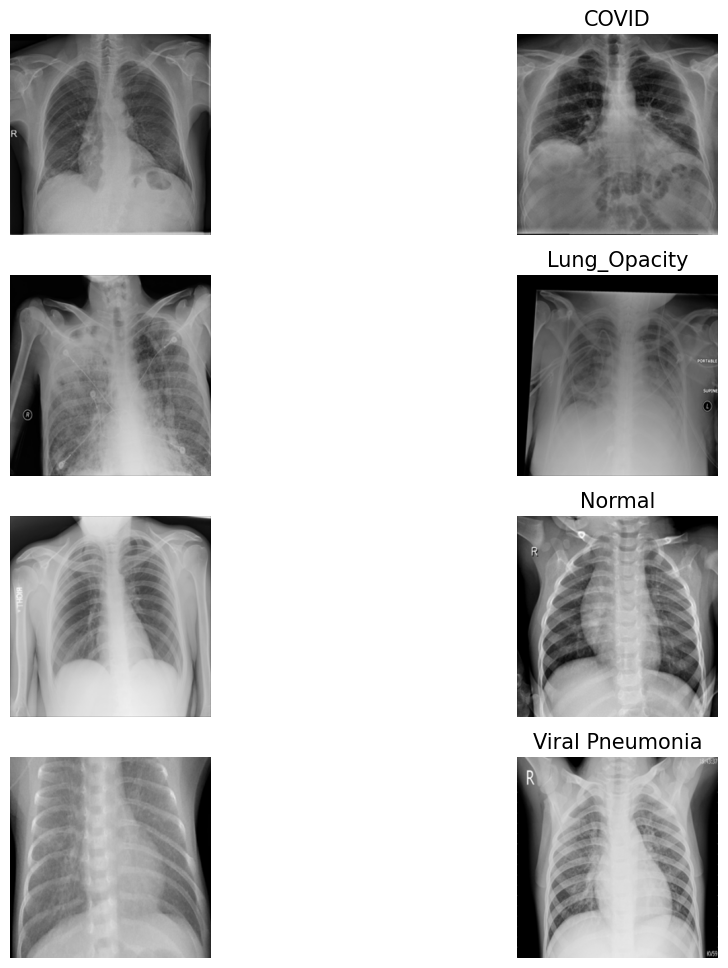

In [ ]:
#visualisation

n_samples = 2

fig, m_axs = plt.subplots(4, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['result']).groupby('result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

<ipython-input-6-6e24529e5eb0>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  sx.set_xticklabels(labels=sx.get_xticklabels(), rotation=90)


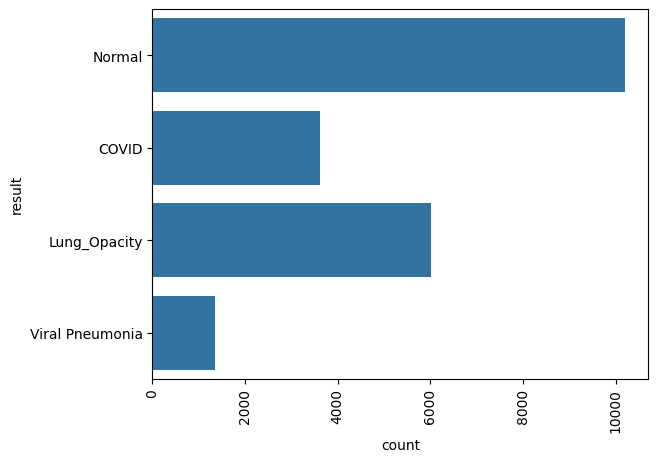

In [ ]:
sx = sns.countplot(data['result'])
sx.set_xticklabels(labels=sx.get_xticklabels(), rotation=90)
plt.show()

In [ ]:
print('Normal : ', list(data['result']).count('Normal'))
print('Covid : ', list(data['result']).count('COVID'))
print('Opacity : ', list(data['result']).count('Lung_Opacity'))
print('VIral Pneumonia : ', list(data['result']).count('Viral Pneumonia'))
#10192 images sont normales

Normal :  10192
Covid :  3616
Opacity :  6012
VIral Pneumonia :  1345


In [ ]:
round(data['result'].value_counts() / data.shape[0] * 100,2)

Normal             48.15
Lung_Opacity       28.41
COVID              17.08
Viral Pneumonia     6.35
Name: result, dtype: float64

In [ ]:
pixel_img = []

for image in tqdm(data['path']):
    img=Image.open(image)
    img=ImageOps.grayscale(img)
    img=img.resize((64,64))
    img=np.asarray(img)
    img=img.reshape((64,64,1))
    pixel_img.append(img)

100%|██████████| 21165/21165 [00:44<00:00, 473.46it/s]


In [ ]:
pixel_img = np.array(pixel_img)
label_img = data['result'].map({'Normal': 0, 'COVID': 1, 'Lung_Opacity' : 2,
                               'Viral Pneumonia' : 3})

print(pixel_img.shape, label_img.shape)

(21165, 64, 64, 1) (21165,)


In [ ]:
#20% will be used for test
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img,
                                                    test_size=0.2, stratify=label_img)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#16932 images for train et 4233 for test

(16932, 64, 64, 1)
(4233, 64, 64, 1)
(16932,)
(4233,)


In [ ]:
round(y_train.value_counts() / y_train.shape[0] * 100,2)

0    48.16
2    28.40
1    17.09
3     6.35
Name: result, dtype: float64

In [ ]:
input_size = X_train.shape[1] * X_train.shape[2]
print(input_size)

num_classes = len(np.unique(y_train))
print(num_classes)

4096
4


In [ ]:
# flatten the image
X_train = np.reshape(X_train, [X_train.shape[0], input_size])
X_train = X_train.astype('float32') / 255

X_test = np.reshape(X_test, [X_test.shape[0], input_size])
X_test = X_test.astype('float32') / 255

## Machine learning models

In [ ]:
from sklearn import svm

# Train the SVM
svm_model = svm.SVC(kernel='rbf')
svm_model.fit(X_train,y_train)

# Evaluate the model
y_pred = svm_model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.8237656508386487

In [ ]:
from sklearn import svm

mo=svm.SVC(kernel='rbf')
mo.fit(X_train,y_train)

y_pred=mo.predict(X_test)
accuracy_score(y_test,y_pred)

In [ ]:
# confusion matrix and accuracy

from sklearn import metrics
from sklearn.metrics import classification_report

print(f"Classification report for classifier {svm_model}:\n"
      f"{metrics.classification_report(y_test, y_pred)}\n")

Classification report for classifier SVC():
              precision    recall  f1-score   support

           0       0.82      0.91      0.87      2038
           1       0.83      0.66      0.73       723
           2       0.80      0.76      0.78      1203
           3       0.92      0.89      0.91       269

    accuracy                           0.82      4233
   macro avg       0.84      0.80      0.82      4233
weighted avg       0.82      0.82      0.82      4233




In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train the MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train,y_train)

# Evaluate the model
y_pred = nb_model.predict(X_test)

In [ ]:
# confusion matrix and accuracy

from sklearn import metrics
from sklearn.metrics import classification_report

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"Classification report for classifier {nb_model}:\n"
      f"{metrics.classification_report(y_test, y_pred)}\n")

Accuracy: 0.553508150248051
Classification report for classifier MultinomialNB():
              precision    recall  f1-score   support

           0       0.77      0.51      0.62      2038
           1       0.33      0.53      0.40       723
           2       0.62      0.57      0.59      1203
           3       0.38      0.86      0.53       269

    accuracy                           0.55      4233
   macro avg       0.52      0.62      0.54      4233
weighted avg       0.63      0.55      0.57      4233




## ConvNet

In [ ]:
# Reconstruct 2D matrix 64x64
# 20% for test

X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img,
                                                    test_size=0.2, stratify=label_img)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

input_shape = (X_train.shape[1],X_train.shape[2],1)

(16932, 64, 64, 1)
(4233, 64, 64, 1)
(16932, 4)
(4233, 4)


In [ ]:
cnn_model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
cnn_model1.summary()

In [ ]:
cnn_model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32,kernel_size(3,3),padding='valid',activation='relu'),
        layers.Conv2D(32,kernel_size(3,3),padding='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2)),
        layers.Dropout(0.2,seed=235),
        layers.Conv2D(32,kernel_size(3,3),padding='valid',activation='relu'),
        layers.Conv2D(32,kernel_size(3,3),padding='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2)),
        layers.Dropout(0.2,seed=235),
        layers.Conv2D(32,kernel_size(3,3),padding='valid',activation='relu'),
        layers.Conv2D(32,kernel_size(3,3),padding='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2)),
        layers.Dropout(0.2,seed=235),
        layers.Flatten(),
        layers.Dropout(0.5,seed=235),
        layers.Dense(512,activation='relu')
        layers.Dense(num_classes,activation='softmax'),
    ]
)
cnn_model1.summary()

In [ ]:
cnn_model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

start_time = time.time()
history = cnn_model1.fit(X_train, y_train, epochs=50, batch_size=128)
print("Temps de calcul :", time.time() - start_time)

Epoch 1/50
133/133 [==============================] - 13s 38ms/step - loss: 0.9567 - accuracy: 0.6056
Epoch 2/50
133/133 [==============================] - 4s 31ms/step - loss: 0.7075 - accuracy: 0.7144
Epoch 3/50
133/133 [==============================] - 4s 32ms/step - loss: 0.6101 - accuracy: 0.7592
Epoch 4/50
133/133 [==============================] - 4s 31ms/step - loss: 0.5514 - accuracy: 0.7838
Epoch 5/50
133/133 [==============================] - 4s 31ms/step - loss: 0.4846 - accuracy: 0.8134
Epoch 6/50
133/133 [==============================] - 4s 32ms/step - loss: 0.4489 - accuracy: 0.8292
Epoch 7/50
133/133 [==============================] - 4s 32ms/step - loss: 0.4112 - accuracy: 0.8467
Epoch 8/50
133/133 [==============================] - 4s 32ms/step - loss: 0.3872 - accuracy: 0.8534
Epoch 9/50
133/133 [==============================] - 4s 32ms/step - loss: 0.3723 - accuracy: 0.8600
Epoch 10/50
133/133 [==============================] - 4s 32ms/step - loss: 0.3418 - accur

In [ ]:
loss, acc = cnn_model1.evaluate(X_test, y_test, verbose=0)

print("Accuracy model8 adam: %.2f%%" % (100.0 * acc))

predictions = cnn_model1.predict(X_test)
pd.crosstab(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

Accuracy model8 adam: 91.54%
133/133 [==============================] - 0s 2ms/step


col_0,0,1,2,3
row_0,,,,
0,1915,13,94,16
1,11,668,41,3
2,163,5,1033,2
3,4,3,3,259


In [ ]:
# confusion matrix and accuracy

from sklearn import metrics
from sklearn.metrics import classification_report

print("Classification report for classifier :\n"
      f"{metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))}\n")

Classification report for classifier :
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      2038
           1       0.97      0.92      0.95       723
           2       0.88      0.86      0.87      1203
           3       0.93      0.96      0.94       269

    accuracy                           0.92      4233
   macro avg       0.92      0.92      0.92      4233
weighted avg       0.92      0.92      0.92      4233




In [ ]:
cnn_model2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
cnn_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 31, 31, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 32)        9248      
                                                      

In [ ]:
cnn_model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

start_time = time.time()
history = cnn_model2.fit(X_train, y_train, epochs=50, batch_size=128)
print("Temps de calcul :", time.time() - start_time)

Epoch 1/50
133/133 [==============================] - 8s 36ms/step - loss: 1.1295 - accuracy: 0.5177
Epoch 2/50
133/133 [==============================] - 5s 34ms/step - loss: 0.8385 - accuracy: 0.6568
Epoch 3/50
133/133 [==============================] - 5s 35ms/step - loss: 0.7262 - accuracy: 0.7061
Epoch 4/50
133/133 [==============================] - 5s 34ms/step - loss: 0.6605 - accuracy: 0.7372
Epoch 5/50
133/133 [==============================] - 5s 35ms/step - loss: 0.6268 - accuracy: 0.7528
Epoch 6/50
133/133 [==============================] - 5s 40ms/step - loss: 0.5861 - accuracy: 0.7713
Epoch 7/50
133/133 [==============================] - 5s 41ms/step - loss: 0.5416 - accuracy: 0.7884
Epoch 8/50
133/133 [==============================] - 5s 35ms/step - loss: 0.5161 - accuracy: 0.7974
Epoch 9/50
133/133 [==============================] - 5s 34ms/step - loss: 0.4838 - accuracy: 0.8176
Epoch 10/50
133/133 [==============================] - 5s 35ms/step - loss: 0.4590 - accura

In [ ]:
loss, acc = cnn_model2.evaluate(X_test, y_test, verbose=0)

print("Accuracy model8 adam: %.2f%%" % (100.0 * acc))

predictions = cnn_model2.predict(X_test)
pd.crosstab(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

Accuracy model8 adam: 91.83%
133/133 [==============================] - 0s 2ms/step


col_0,0,1,2,3
row_0,,,,
0,1890,33,94,21
1,12,697,12,2
2,122,41,1035,5
3,2,2,0,265


In [ ]:
# confusion matrix and accuracy

from sklearn import metrics
from sklearn.metrics import classification_report

print("Classification report for classifier :\n"
      f"{metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))}\n")

Classification report for classifier :
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2038
           1       0.90      0.96      0.93       723
           2       0.91      0.86      0.88      1203
           3       0.90      0.99      0.94       269

    accuracy                           0.92      4233
   macro avg       0.91      0.93      0.92      4233
weighted avg       0.92      0.92      0.92      4233




In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="IHZ6TVDz3MTd1tmO9V4l")
project = rf.workspace("roboflow-100").project("solar-panels-taxvb")
version = project.version(2)
dataset = version.download("yolov8")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.9/70.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.1

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to solar-panels-2 in yolov8:: 100%|██████████| 334/334 [00:00<00:00, 1874.50it/s]
